# Making stuff

In [2]:
import copy
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json
import collections
import itertools
import time

import numpy as onp
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad, lax
from jax.scipy import stats
from jax.ops import index_update, index
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot
from tqdm import tqdm

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
key, rkey = random.split(rkey)

In [3]:
f = metrics.Funnel(2)

In [4]:
s = f.sample(1000)

(-10.0, 10.0)

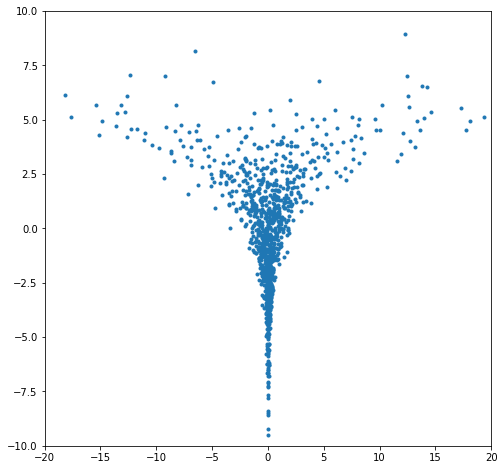

In [11]:
fig, ax = plt.subplots(figsize=[8, 8])
plot.scatter(s, ax=ax, marker=".")
ax.set_xlim((-20, 20))
ax.set_ylim((-10, 10))

# Goal: see if MLP can learn optimal encoding for funnel

In [ ]:
def enc_funnel(z):
    """encode single sample z, shaped (d,)"""
    *x, y = z
    x, y = np.asarray(x), np.asarray(y)
    x_enc = x * np.exp(-y/2)
    return np.append(x_enc, y)

def dec_funnel(z):
    """decode single sample z, shaped (d,)"""
    *x, y = z
    x, y = np.asarray(x), np.asarray(y)
    x_dec = x * np.exp(y/2)
    return np.append(x_dec, y)


In [ ]:
x = random.normal(key, (10000, 2))
x = x * np.array([1, 3])
z = vmap(dec_funnel)(x)

fig, ax = plt.subplots(figsize=[5,5])
ax.scatter(z[:, 0], z[:, 1])

## learn encoding

In [ ]:
funnel = metrics.Funnel(2)
encoder = hk.transform(kernels.make_mlp([8, 8, 8, 8, 2], name="encoder", skip_connection=True))
def loss(encoder_params, x):
    return np.linalg.norm(encoder.apply(encoder_params, None, x) - enc_funnel(x))**2
@jit
def loss_batched(encoder_params, x):
    return np.mean(vmap(loss, (None, 0))(encoder_params, x))

key, subkey = random.split(key)
x_dummy = np.asarray([1., 1.])
init_params = encoder.init(subkey, x_dummy)
opt = svgd.Optimizer(*optimizers.adam(0.01))
opt_state = opt.init(init_params)

nsteps=1000
losses=[]
for step in tqdm(range(nsteps)):
    x = funnel.sample(500)
    encoder_params = opt.get_params(opt_state)
    l, g = value_and_grad(loss_batched, argnums=0)(encoder_params, x)
    opt_state = opt.update(step, g, opt_state)
    losses.append(l)

In [ ]:
plt.plot(losses)
plt.yscale("log")

## see if it worked

In [ ]:
def enc_mlp(z): return encoder.apply(encoder_params, None, z)

z = f.sample(1000)
encoded = vmap(enc_funnel)(z)
mlp_encoded = vmap(enc_mlp)(z)

fig, ax = plt.subplots(figsize=[5,6])
# ax=axs[0]
ax.scatter(encoded[:, 0], encoded[:, 1], marker=".", label="Fixed encoded")
# ax=axs[0]
ax.scatter(mlp_encoded[:, 0], mlp_encoded[:, 1], marker=".", label="Learned encoding")
plt.legend()

# Does the encoded kernel have larger ksd than the rbf kernel?

TODO
* make sure we're using a near-maximal bandwidth for the KSD to the standard normal
* 

In [ ]:
n=5000
key, s1, s2 = random.split(key, 3)
# x = random.normal(s1, (n, 2))    # P = N(0_2, I)
y = random.normal(s2, (n, 2)) -2 # Q = N([-2,-2], I)

def t(v):
    """if v~N(0_2, I_2), then output w~Funnel(2)"""
    *x, y = v
    x, y = np.asarray(x), np.asarray(y)
    y = y*3
    x = x*np.exp(y/2)
    return np.append(x, y)
# tx = vmap(t)(x) # T(X) ~ Funnel(2)
ty = vmap(t)(y) # T(Y)

qloc = np.asarray([-2, -2])
ploc = np.asarray([0, 0])
qscale = onp.diag([1, 1])
pscale = onp.diag([1, 1])
def logp(x): return stats.multivariate_normal.logpdf(x, mean=ploc, cov=pscale)

# get both kernel functions
rbf = kernels.ard(logh=-5)
def rbf_enc(x, y): return rbf(enc_funnel(x), enc_funnel(y))

print("P ~ N(0, I_2)")
print("Q ~ N(-2, I_2)")
print("T_#P is dist of T(X) when X~P. That is, F = Neal's Funnel")
print("T_#Q is dist of T(Y) when Y~Q")
print("--------------")
print("Now estimate the KSD.")
# print("# V-statistics:")
# print("KSD(Q, P      ;rbf)     =", stein.ksd_squared_u(y, logp, rbf)) # not equal to below
# print("KSD(T_#Q, T_#P; T_#rbf) =", stein.ksd_squared_v(ty, funnel.logpdf, rbf_enc))
# print("KSD(T_#Q, T_#P; rbf)    =", stein.ksd_squared_v(ty, funnel.logpdf, rbf))

print("# U-statistics:")
print("KSD(T_#Q, T_#P; T_#rbf) =", stein.ksd_squared_u(ty, funnel.logpdf, rbf_enc, False), "(Would like this to be bigger)")
print("KSD(T_#Q, T_#P; rbf)    =", stein.ksd_squared_u(ty, funnel.logpdf, rbf, False))

In [ ]:
# plot.scatter(ty)

### same thing with different proposal Q

In [ ]:
# data should be near the funnel distribution, but not quite right
# (e.g. to wide at the narrow part of the funnel)
zo = funnel.sample(5000)
def mess_up_funnel(zo):
    z = copy.copy(onp.asarray(zo))
    z[z[:, 0]>0, 0] = np.sqrt(z[z[:, 0]>0, 0])
    z[z[:, 0]<0, 0] = -np.sqrt(-z[z[:, 0]<0, 0])
    return z
z = mess_up_funnel(zo)

# compute ksd
print("KSD(Z, F; rbf)    =", stein.ksd_squared_u(z, funnel.logpdf, rbf))
print("KSD(Z, F; T_#rbf) =", stein.ksd_squared_u(z, funnel.logpdf, rbf_enc))

In [ ]:
plot.scatter(z, marker=".")
plt.ylim((-9,9))
plt.xlim((-20, 20))

Sanity check nr 1:

# What happens when we maximize the KSD?
TODO

In [ ]:
# %matplotlib widget
# plot.plot_pdf(f.pdf, (-20, 20), type="3d")